#### MNIST Attack Notebook

In [75]:
import sys

import yaml

sys.path.append("..")

import numpy as np
import pytorch_lightning as pl
import torch
from art.estimators.classification import PyTorchClassifier
from torch import nn

from attacks import ATTACK_MAPPINGS, generate_mask
from models import MODEL_MAPPINGS


def get_xyz(args, autoencoder_model, test_dataloader):
    x_test, y_test = next(iter(test_dataloader))
    x_test, y_test = x_test.to(args.device), y_test.to(args.device)
    x_test_np, y_test_np = x_test.cpu().numpy(), y_test.cpu().numpy()

    z_test = autoencoder_model.get_z(x_test)
    z_test_np = z_test.detach().cpu().numpy()

    return (x_test, x_test_np), (y_test, y_test_np), (z_test, z_test_np)

def get_models(args):
    """
    load the corresponding model and return in the
    eval mode.
    """
    dataset_name = args.model_name.split("_")[0]
    with open(f"./configs/{dataset_name}.yml", "r") as f:
        config = yaml.safe_load(f)

    config["device"]       = torch.device(args.device)
    config["dataset_name"] = dataset_name

    classifier_path = config["classifiers"][args.model_name]
    autoencoder_path = config["autoencoders"][args.ae_name]

    classifier_model_class = MODEL_MAPPINGS[classifier_path]
    autoencoder_model_class = MODEL_MAPPINGS[autoencoder_path]
    import os
    print(os.listdir())
    print(classifier_path)

    classifier_model = classifier_model_class.load_from_checkpoint(classifier_path).to(args.device)
    autoencoder_model = autoencoder_model_class.load_from_checkpoint(autoencoder_path).to(args.device)

    classifier_model.eval()
    autoencoder_model.eval()

    return classifier_model, autoencoder_model, config

def hybridize(x, y, z, config, classifier_model, autoencoder_model):
    hybrid_classifier_model = nn.Sequential(
            autoencoder_model.decoder,
            classifier_model.model
        ).to("cpu")

    miscs = config["miscs"]
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(mnist_classifier.parameters(), lr=0.01)

    # Step 4: Create the ART classifier
    classifier = PyTorchClassifier( 
        model=classifier_model,
        clip_values=(miscs["min_pixel_value"], miscs["max_pixel_value"]),
        loss=criterion,
        # optimizer=optimizer,
        input_shape=tuple(miscs["input_shape"]),
        nb_classes=miscs["nb_classes"],
    )
    hybrid_classifier = PyTorchClassifier(
        model=hybrid_classifier_model,
        # clip_values=(min_pixel_value, max_pixel_value),
        loss=criterion,
        # optimizer=optimizer,
        input_shape=(1, config["latent_shape"]),
        nb_classes=miscs["nb_classes"],
    )

    # Step 5: Evaluate the ART classifier on benign test examples
    predictions = classifier.predict(x[1])
    accuracy = np.sum(np.argmax(predictions, -1) == y[1])/ len(y[1])
    print("Accuracy on benign test examples: {}%".format(accuracy * 100))

    # from torchsummary import summary
    # summary(hybrid_classifier_model, (128, 16, 16))
    predictions = hybrid_classifier.predict(z[1])
    accuracy = np.sum(np.argmax(predictions, -1) == y[1])/ len(y[1])
    print("Accuracy on benign test examples(from reconstructed): {}%".format(accuracy * 100))

    return classifier, hybrid_classifier, accuracy

def execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model, conditionals, kwargs):
    result = {}
    name = attack_name.__name__
    result[name] = {}
    
    # ------------------------------------------------- #
    # ---------------- Original Attack ---------------- #
    # ------------------------------------------------- #
    if conditionals["calculate_original"]:
        attack = attack_name(classifier, **kwargs)
        x_adv = attack.generate(x=x[1])
        predictions = classifier.predict(x_adv)
        x_adv_acc = np.sum(np.argmax(predictions, axis=-1) == y[1]) / len(y[1])

        result[name]["x_adv"] = x_adv
        result[name]["x_adv_acc"] = x_adv_acc

        # calculate noise
        delta_x = x_adv - x[1]
        result[name]["delta_x"] = delta_x
        print("Robust accuracy of original adversarial attack: {}%".format(x_adv_acc * 100))

    # ------------------------------------------------- #
    # ---------------- Modified Attack ---------------- #
    # ------------------------------------------------- #
    modified_attack = attack_name(hybrid_classifier, **kwargs)
    if conditionals["is_class_constrained"]:
        z_adv = modified_attack.generate(x=z[1], mask=generate_mask(
            latent_dim=int(config["latent_shape"]),
            n_classes=config["miscs"]["nb_classes"],
            labels=y[1]))
    else:
        z_adv = modified_attack.generate(x=z[1])
    
    print(np.linalg.norm(z_adv - z[1]))

    # calculate noise
    autoencoder_model = autoencoder_model.to(config["device"])
    x_hat_adv         = autoencoder_model.decoder(torch.Tensor(z_adv).to(config["device"]))
    x_hat             = autoencoder_model.decoder(torch.Tensor(z[1]).to(config["device"]))
    delta_x_hat       = x_hat_adv - x_hat

    # modified attack
    plot_images(x_hat_adv.detach().cpu().numpy())
    # plot_images(x_hat_adv)

    modf_x_adv   = x[1] + delta_x_hat.cpu().detach().numpy()
    predictions = classifier.predict(modf_x_adv)
    modf_x_adv_acc = np.sum(np.argmax(predictions, axis=-1) == y[1]) / len(y[1])

    result[name]["modf_x_adv"] = modf_x_adv
    result[name]["modf_x_adv_acc"] = modf_x_adv_acc

    # reconstructed attack
    # predictions = hybrid_classifier.predict(z_adv)
    # x_hat_adv_acc = np.sum(np.argmax(predictions, axis=-1) == y[1]) / len(y[1])

    result[name]["z_adv"] = z_adv
    result[name]["x_hat_adv"] = x_hat_adv.cpu().detach().numpy()
    # result[name]["x_hat_adv_acc"] = x_hat_adv_acc
    
    # send combined noise
    result[name]["delta_x_hat"] = delta_x_hat.cpu().detach().numpy()

    print("Robust accuracy of modified adversarial attack: {}%".format(modf_x_adv_acc * 100))
    # print("Robust accuracy of reconstructed adversarial attack: {}%".format(x_hat_adv_acc * 100))

    return result

In [76]:
%%capture installation
import os
import sys
import argparse
import datetime

import numpy as np

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder,
                                MNISTCNNAutoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                               MNISTClassifier, MNISTCNNClassifier)

from attacks import ATTACK_MAPPINGS
# from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [88]:
class Args:
    batch_size = 100
    attack_name = "deepfool"
    device  = "mps"
    model_name = "mnist_ann_1"
    ae_name = "ann_128"
    plot = False
    plot_dir = "./plots"
    # kwargs = {"norm": "inf", "eps": 0.01} # fgsm
    # kwargs = {"eps": 0.8, "eps_step": 0.1, "max_iter": 100} # bim
    kwargs = {} # deepfool

args = Args()

In [89]:
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, _, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader {config['dataset_name']}!!!!!") 

Working on the dataset: mnist!!!!!
['comments.txt', 'attack_main.py', '.DS_Store', 'LICENSE', 'mnist_attack.ipynb', 'objects', 'models', '__pycache__', 'README.md', 'img', 'dataset.py', 'cifar10_attack.ipynb', '.gitignore', 'utils.py', 'visualise_tsne.py', 'cifar10_attack_uq.ipynb', 'plot_attack.py', 'visualise_logs.ipynb', 'defences', 'configs', 'visualise_tsne.ipynb', 'art_attack.py', 'dataloader.py', '.ipynb_checkpoints', 'celeba_attack.ipynb', '.git', 'art_attack.ipynb', 'lightning_logs', 'plots', 'attacks', 'semantic_optimization_attack.ipynb']
./lightning_logs/mnist_classifier/checkpoints/epoch=9-step=9370.ckpt
Loaded classifier and autoencoder models in eval mode!!!!!
Loaded dataloader mnist!!!!!


Accuracy on benign test examples: 100.0%
Accuracy on benign test examples(from reconstructed): 99.0%


DeepFool: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s]

44.118896


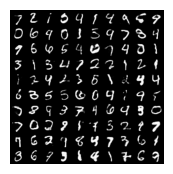

Robust accuracy of modified adversarial attack: 40.0%


In [90]:
x, y, z = get_xyz(args, autoencoder_model, test_dataloader)
x = list(x)

# x[0] = x[0].reshape((-1, 1, 28, 28))
# x[1] = x[1].reshape((-1, 1, 28, 28))

config["latent_shape"] = args.ae_name.split('_')[-1]
classifier, hybrid_classifier, accuracy = hybridize(x, y, z, 
                                                    config, classifier_model.to(config["device"]),
                                                    autoencoder_model.to(config["device"]))

# Perform attack
conditionals = {
    "calculate_original": False,
    "is_class_constrained": False
}

result: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model, conditionals, args.kwargs)

In [87]:
if conditionals["calculate_original"]:
    x_adv = result[attack_name.__name__]["x_adv"]
    delta_x = result[attack_name.__name__]["delta_x"]

x_hat_adv  = result[attack_name.__name__]["x_hat_adv"]
modf_x_adv = result[attack_name.__name__]["modf_x_adv"]

# noises
delta_x_hat = result[attack_name.__name__]["delta_x_hat"]

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 1, 28, 28)

    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(0,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

start = 0
end   = 10

In [44]:
if conditionals["calculate_original"]:
    plot_images(x_adv[start: end])

if conditionals["calculate_original"]:
    plot_images(delta_x[start: end])

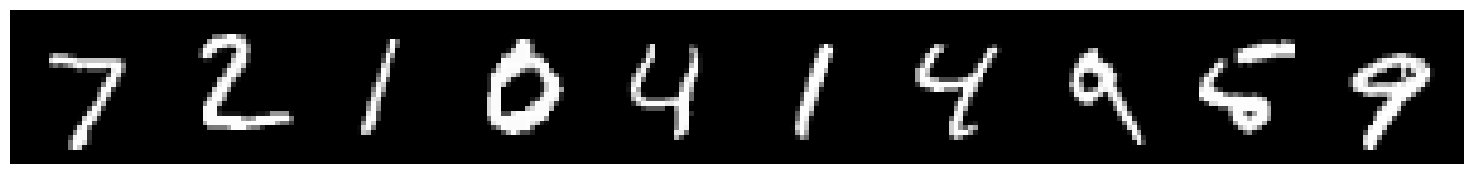

In [45]:
plot_images(x[1][start: end])

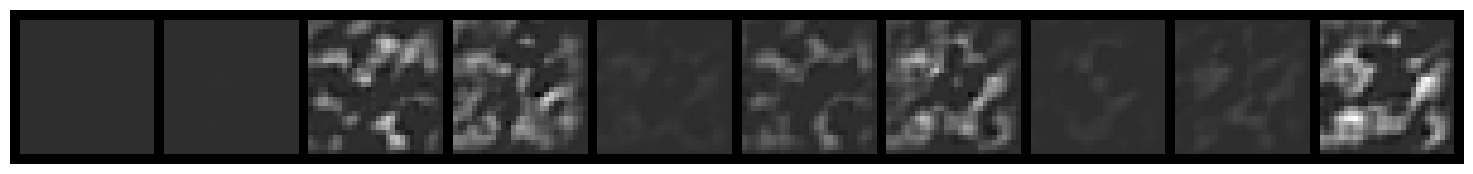

In [46]:
plot_images(modf_x_adv[start: end])

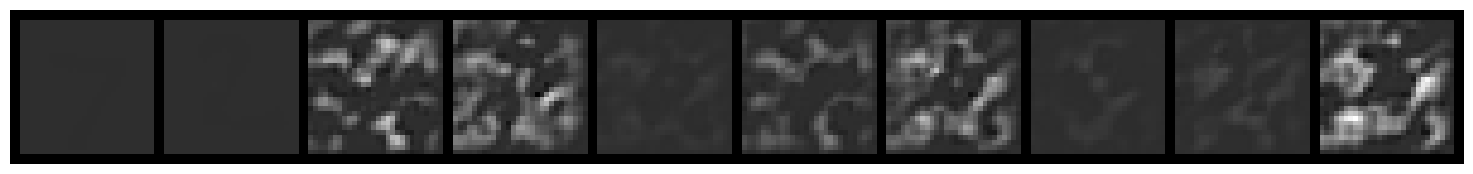

In [37]:
plot_images(delta_x_hat[start: end])

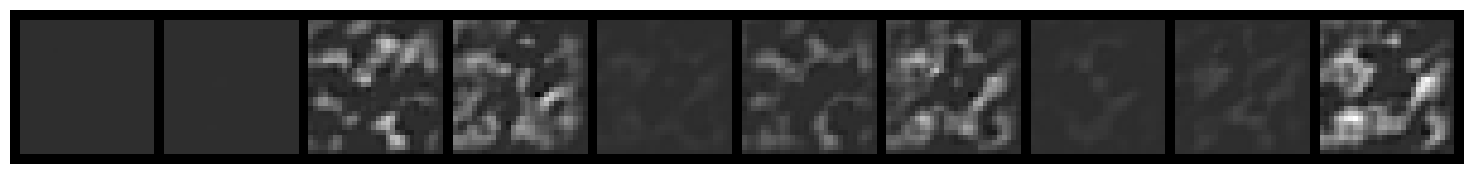

In [38]:
plot_images(x_hat_adv[start: end])

##### Visualising Latent Code

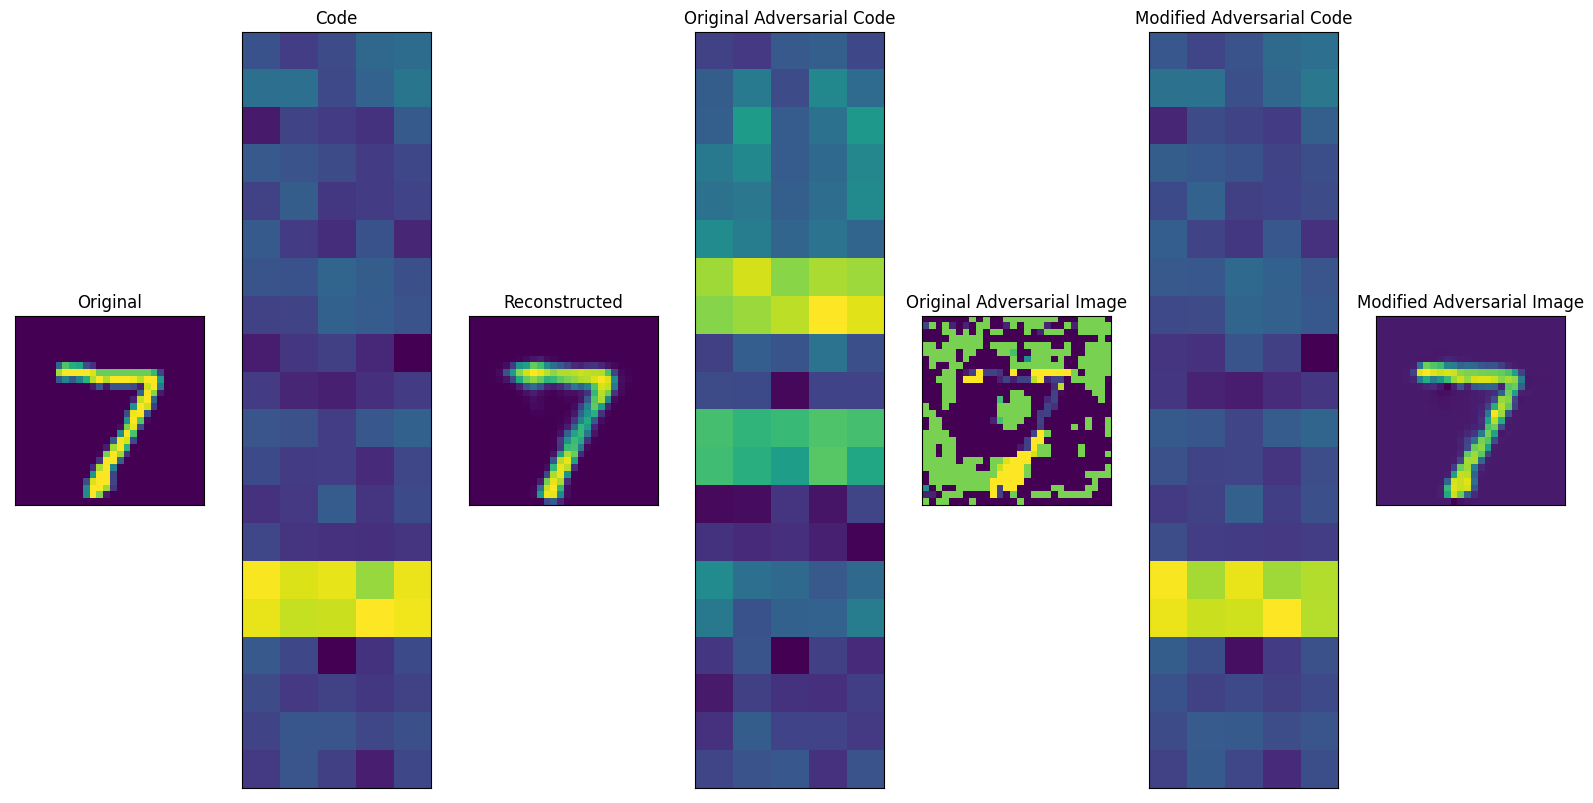

In [46]:
import torch
import matplotlib.pyplot as plt

def plot_recons_with_latent_codes(x, z, x_hat, z_adv, x_adv, zz_adv, xx_adv):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,7,1, xticks=[], yticks=[])
    plt.title("Original")
    plt.imshow(x.reshape((28, 28)))

    plt.subplot(1,7,2, xticks=[], yticks=[])
    plt.title("Code")
    plt.imshow(z.reshape([z.shape[-1]//5,-1]).cpu().detach().numpy())

    plt.subplot(1,7,3, xticks=[], yticks=[])
    plt.title("Reconstructed")
    plt.imshow(x_hat.reshape((28, 28)))

    plt.subplot(1,7,4, xticks=[], yticks=[])
    plt.title("Original Adversarial Code")
    plt.imshow(z_adv.reshape([z.shape[-1]//5,-1]))

    plt.subplot(1,7,5, xticks=[], yticks=[])
    plt.title("Original Adversarial Image")
    plt.imshow(x_adv.reshape((28, 28)))

    plt.subplot(1,7,6, xticks=[], yticks=[])
    plt.title("Modified Adversarial Code")
    plt.imshow(zz_adv.reshape([z.shape[-1]//5,-1]))

    plt.subplot(1,7,7, xticks=[], yticks=[])
    plt.title("Modified Adversarial Image")
    plt.imshow(xx_adv.reshape((28, 28)))
    plt.show()

autoencoder_model = autoencoder_model.to(args.device)
x_hat, z, preds = autoencoder_model(x[0].to(args.device))
x_hat = x_hat.cpu().detach().numpy()

x_adv = torch.Tensor(result[attack_name.__name__]["x_test_adv_np"])
_, z_adv, preds = autoencoder_model(x_adv.to(args.device))
z_adv = z_adv.cpu().detach().numpy()

zz_adv = result[attack_name.__name__]["z_test_adv_np"]
xx_adv = result[attack_name.__name__]["xx_test_adv_np"]
plot_recons_with_latent_codes(x[1], z, x_hat, z_adv, x_adv, zz_adv, xx_adv)

##### LPIPS

In [119]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
import torchvision.transforms.functional as fn

img0 = fn.resize(torch.Tensor(orig_attk_images).reshape(-1, 1, 28, 28).tile((1, 3, 1, 1)), [32]) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = fn.resize(x[0].detach().cpu().reshape(-1, 1, 28, 28).tile((1, 3, 1, 1)), [32])

d = loss_fn_alex(img0, img1)
print(d.flatten())

img0 = fn.resize(torch.Tensor(modf_attk_images).reshape(-1, 1, 28, 28).tile((1, 3, 1, 1)), [32]) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = fn.resize(x[0].detach().cpu().reshape(-1, 1, 28, 28).tile((1, 3, 1, 1)), [32])

d = loss_fn_alex(img0, img1)
print(d.flatten())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
tensor([0.2396, 0.1845, 0.4810, 0.2265, 0.2968, 0.4007, 0.1918, 0.1974, 0.1212,
        0.2061], grad_fn=<ReshapeAliasBackward0>)
tensor([0.0299, 0.0107, 0.1301, 0.0160, 0.0371, 0.0672, 0.0231, 0.0148, 0.0097,
        0.0324], grad_fn=<ReshapeAliasBackward0>)


In [ ]:
# Host uq-cvl
#     HostName 10.237.23.130
#     User sweta